In [1]:
#Import all libraries
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from datetime import datetime
import itertools
import re
import os
import pickle
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

#Global variables
max_val = 0
models_folder = 'rl_trader_models'
rewards_folder = 'rl_trader_rewards'
num_episodes = 1000
batch_size = 32
initial_investment = 20000
scaler1 = None


In [2]:
#Load stock data from csv
def load_stock_data():
  # 0 = Apple
  # 1 = Motorola
  # 2 = Starbucks
  df = pd.read_csv('aapl_msi_sbux.csv')
  print(df.head())    
  return df.values



#Experience replay used to make training DQN easier
class Exp_replay_buffer:
  def __init__(self, obs_dim, act_dim, size):
    self.obs1_buf = np.zeros([size, obs_dim], dtype=np.float32)
    self.obs2_buf = np.zeros([size, obs_dim], dtype=np.float32)
    self.acts_buf = np.zeros(size, dtype=np.uint8)
    self.rews_buf = np.zeros(size, dtype=np.float32)
    self.done_buf = np.zeros(size, dtype=np.uint8)
    self.ptr, self.size, self.max_size = 0, 0, size

  def store(self, obs, act, rew, next_obs, done):
    self.obs1_buf[self.ptr] = obs
    self.obs2_buf[self.ptr] = next_obs
    self.acts_buf[self.ptr] = act
    self.rews_buf[self.ptr] = rew
    self.done_buf[self.ptr] = done
    self.ptr = (self.ptr+1) % self.max_size
    self.size = min(self.size+1, self.max_size)

  def select_rand_batch(self, batch_size=32):
    idxs = np.random.randint(0, self.size, size=batch_size)
    return dict(s=self.obs1_buf[idxs],
                s2=self.obs2_buf[idxs],
                a=self.acts_buf[idxs],
                r=self.rews_buf[idxs],
                d=self.done_buf[idxs])




#Create scaler to scale stock values between 0 to 1
def create_scaler(env):
  

  states = []
  for _ in range(env.n_step):
    action = np.random.choice(env.action_space)
    state, reward, done, info = env.step(action)
    states.append(state)
    if done:
      break

  scaler = StandardScaler()
  scaler.fit(states)
  return scaler




def maybe_make_dir(directory):
  if not os.path.exists(directory):
    os.makedirs(directory)




In [3]:
class MLP(nn.Module):
  def __init__(self, n_inputs, n_action, n_hidden_layers=2, hidden_dim=64):
    super(MLP, self).__init__()

    M = n_inputs
    self.layers = []
    for _ in range(n_hidden_layers):
      layer = nn.Linear(M, hidden_dim)
      M = hidden_dim
      self.layers.append(layer)
      self.layers.append(nn.ReLU())

    # final layer
    self.layers.append(nn.Linear(M, n_action))
    self.layers = nn.Sequential(*self.layers)

  def forward(self, X):
    return self.layers(X)

  def save_weights(self, path):
    torch.save(self.state_dict(), path)

  def load_weights(self, path):
    self.load_state_dict(torch.load(path))



def predict(model, np_states):
  with torch.no_grad():
    inputs = torch.from_numpy(np_states.astype(np.float32))
    output = model(inputs)
    # print("output:", output)
    return output.numpy()



def train_one_step(model, criterion, optimizer, inputs, targets):
  # convert to tensors
  inputs = torch.from_numpy(inputs.astype(np.float32))
  targets = torch.from_numpy(targets.astype(np.float32))

  # zero the parameter gradients
  optimizer.zero_grad()

  # Forward pass
  outputs = model(inputs)
  loss = criterion(outputs, targets)
        
  # Backward and optimize
  loss.backward()
  optimizer.step()



class MultiStockEnv:
  """
States: 
#No. of shares in stock 1
#No. of shares in stock 2
#No. of shares in stock 3
#Price of stock 1
#Price of stock 2
#Price of stock 3
#Money in hand

  """
  def __init__(self, data, initial_investment=20000):
    # data
    self.stock_price_history = data
    self.n_step, self.n_stock = self.stock_price_history.shape

    # instance attributes
    self.initial_investment = initial_investment
    self.cur_step = None
    self.stock_owned = None
    self.stock_price = None
    self.cash_in_hand = None

    self.action_space = np.arange(3**self.n_stock)

    self.action_list = list(map(list, itertools.product([0, 1, 2], repeat=self.n_stock)))

    # calculate size of state
    self.state_dim = self.n_stock * 2 + 1

    self.reset()


  def reset(self):
    self.cur_step = 0
    self.stock_owned = np.zeros(self.n_stock)
    self.stock_price = self.stock_price_history[self.cur_step]
    self.cash_in_hand = self.initial_investment
    return self._get_obs()


  def step(self, action):
    assert action in self.action_space

    # update prev value to value before trading is done 
    prev_val = self._get_val()

    # GO to next day, update prices
    self.cur_step += 1
    self.stock_price = self.stock_price_history[self.cur_step]

    # Do the trade 
    self._trade(action)

    # get the new value after trading
    cur_val = self._get_val()

    # reward is the increase in porfolio value
    reward = cur_val - prev_val

    # done if we have run out of data
    done = self.cur_step == self.n_step - 1

    # store the current value of the portfolio here
    info = {'cur_val': cur_val}

    # conform to the Gym API
    return self._get_obs(), reward, done, info


  def _get_obs(self):
    obs = np.empty(self.state_dim)
    obs[:self.n_stock] = self.stock_owned
    obs[self.n_stock:2*self.n_stock] = self.stock_price
    obs[-1] = self.cash_in_hand
    return obs
    


  def _get_val(self):
    return self.stock_owned.dot(self.stock_price) + self.cash_in_hand


  def _trade(self, action):
    
    action_vec = self.action_list[action]

    
    sell_index = [] # stores index of stocks we want to sell
    buy_index = [] # stores index of stocks we want to buy
    for i, a in enumerate(action_vec):
      if a == 0:
        sell_index.append(i)
      elif a == 2:
        buy_index.append(i)

   
    if sell_index:
      # NOTE: to simplify the problem, when we sell, we will sell ALL shares of that stock
      for i in sell_index:
        self.cash_in_hand += self.stock_price[i] * self.stock_owned[i]
        self.stock_owned[i] = 0
    if buy_index:
   
      can_buy = True
      while can_buy:
        for i in buy_index:
          if self.cash_in_hand > self.stock_price[i]:
            self.stock_owned[i] += 1 # buy one share
            self.cash_in_hand -= self.stock_price[i]
          else:
            can_buy = False





In [4]:


class DQNAgent(object):
  def __init__(self, state_size, action_size):
    self.state_size = state_size
    self.action_size = action_size
    self.memory = Exp_replay_buffer(state_size, action_size, size=100)
    self.gamma = 0.95  # discount rate
    self.epsilon = 1.0  # exploration rate
    self.epsilon_min = 0.01
    self.epsilon_decay = 0.995
    self.model = MLP(state_size, action_size)

    # Loss and optimizer
    self.criterion = nn.MSELoss()
    self.optimizer = torch.optim.Adam(self.model.parameters())


  def update_replay_memory(self, state, action, reward, next_state, done):
    self.memory.store(state, action, reward, next_state, done)


  def act(self, state):
    if np.random.rand() <= self.epsilon:
      return np.random.choice(self.action_size)
    act_values = predict(self.model, state)
    return np.argmax(act_values[0])  # returns action


  def replay(self, batch_size=32):
    # wait to fill up buffer
    if self.memory.size < batch_size:
      return

    # sample a batch of data from the replay memory
    minibatch = self.memory.select_rand_batch(batch_size)
    states = minibatch['s']
    actions = minibatch['a']
    rewards = minibatch['r']
    next_states = minibatch['s2']
    done = minibatch['d']

    # Calculate the target: Q(s',a)
    target = rewards + (1 - done) * self.gamma * np.amax(predict(self.model, next_states), axis=1)

    # Then, only change the targets for the actions taken.
    # Q(s,a)
    target_full = predict(self.model, states)
    target_full[np.arange(batch_size), actions] = target

    # Run one training step
    train_one_step(self.model, self.criterion, self.optimizer, states, target_full)

    if self.epsilon > self.epsilon_min:
      self.epsilon *= self.epsilon_decay


  def load(self, name):
    self.model.load_weights(name)


  def save(self, name):
    self.model.save_weights(name)


def play_one_episode(agent, env, is_train, scaler):
  # note: after transforming states are already 1xD
  state = env.reset()
  state = scaler.transform([state])
  done = False

  while not done:
    action = agent.act(state)
    next_state, reward, done, info = env.step(action)
    next_state = scaler.transform([next_state])
    if is_train == 'train':
      agent.update_replay_memory(state, action, reward, next_state, done)
      agent.replay(batch_size)
    state = next_state

  return info['cur_val']




In [5]:

def main_func(mode1, epsilon):
  maybe_make_dir(models_folder)
  maybe_make_dir(rewards_folder)

  data = load_stock_data()
  n_timesteps, n_stocks = data.shape

  n_train = n_timesteps // 2

  train_data = data[:n_train]
  test_data = data[n_train:]

  env = MultiStockEnv(train_data, initial_investment)
  state_size = env.state_dim
  action_size = len(env.action_space)
  agent = DQNAgent(state_size, action_size)
  scaler1 = create_scaler(env)

  # store the final value of the portfolio (end of episode)
  portfolio_value = []

  if mode1 == 'test':
    # then load the previous scaler
    with open(f'{models_folder}/scaler.pkl', 'rb') as f:
      scaler1 = pickle.load(f)

    # remake the env with test data
    env = MultiStockEnv(test_data, initial_investment)

   # epsilon = 1 for complete random
   # = 0 for deterministic for all exploitation
    agent.epsilon = epsilon 

    # load trained weights
    agent.load(f'{models_folder}/dqn.ckpt')
    
  

  # play the game num_episodes times
  for e in range(num_episodes):
    t0 = datetime.now()
    val = play_one_episode(agent, env, mode1, scaler1)
    if val > max_val and (e > 800):
      if mode1 == 'train':
        # save the best performing DQN
        agent.save(f'{models_folder}/dqn.ckpt')

        # save the scaler
        with open(f'{models_folder}/scaler.pkl', 'wb') as f:
          pickle.dump(scaler1, f)
    dt = datetime.now() - t0
    print(f"episode: {e + 1}/{num_episodes}, episode end value: {val:.2f}, duration: {dt}")
    portfolio_value.append(val) # append episode end portfolio value

  # save the weights when we are done
  if mode1 == 'train':
    # save the DQN
    agent.save(f'{models_folder}/dqn_last.ckpt')

    # save the scaler
    with open(f'{models_folder}/scaler_last.pkl', 'wb') as f:
      pickle.dump(scaler1, f)


  # save portfolio value for each episode
  np.save(f'{rewards_folder}/{mode1}.npy', portfolio_value)


In [31]:
def plot_func(mode1):
    a = np.load(f'rl_trader_rewards/{mode1}.npy')

    print(f"average reward: {a.mean():.2f}, min: {a.min():.2f}, max: {a.max():.2f}, std: {a.std():.2f}")

    if mode1 == 'train':
  # show the training progress
      plt.plot(a)
      plt.xlabel("Episodes---->")
      plt.ylabel("Portfolio Value---->")
      plt.title("Train series")
    else:
  # test - show a histogram of rewards
      plt.hist(a, bins=64)
      plt.ylabel("Frequency of Episodes---->")
      plt.xlabel("Portfolio Value---->")
      plt.title("Test series")

    
    
    plt.show()


In [7]:

main_func("train", 0.01)



      AAPL    MSI    SBUX
0  67.8542  60.30  28.185
1  68.5614  60.90  28.070
2  66.8428  60.83  28.130
3  66.7156  60.81  27.915
4  66.6556  61.12  27.775
episode: 1/1000, episode end value: 16435.95, duration: 0:00:00.781178
episode: 2/1000, episode end value: 21633.29, duration: 0:00:00.760173
episode: 3/1000, episode end value: 21079.12, duration: 0:00:00.786179
episode: 4/1000, episode end value: 22791.91, duration: 0:00:00.774105
episode: 5/1000, episode end value: 25354.31, duration: 0:00:00.777177
episode: 6/1000, episode end value: 22748.53, duration: 0:00:00.743169
episode: 7/1000, episode end value: 19656.17, duration: 0:00:00.763174
episode: 8/1000, episode end value: 20096.12, duration: 0:00:00.789264
episode: 9/1000, episode end value: 23212.87, duration: 0:00:00.816186
episode: 10/1000, episode end value: 22730.15, duration: 0:00:00.780178
episode: 11/1000, episode end value: 19595.69, duration: 0:00:00.785179
episode: 12/1000, episode end value: 20675.80, duration: 0:00

episode: 113/1000, episode end value: 41400.44, duration: 0:00:00.793428
episode: 114/1000, episode end value: 46283.10, duration: 0:00:00.805183
episode: 115/1000, episode end value: 52211.18, duration: 0:00:00.783178
episode: 116/1000, episode end value: 48715.26, duration: 0:00:00.816186
episode: 117/1000, episode end value: 46658.10, duration: 0:00:00.799776
episode: 118/1000, episode end value: 45433.29, duration: 0:00:00.785179
episode: 119/1000, episode end value: 48495.29, duration: 0:00:00.800182
episode: 120/1000, episode end value: 32732.86, duration: 0:00:00.790709
episode: 121/1000, episode end value: 42510.00, duration: 0:00:00.774176
episode: 122/1000, episode end value: 55773.81, duration: 0:00:00.797182
episode: 123/1000, episode end value: 56508.27, duration: 0:00:00.788179
episode: 124/1000, episode end value: 46044.21, duration: 0:00:00.804909
episode: 125/1000, episode end value: 51322.62, duration: 0:00:00.811185
episode: 126/1000, episode end value: 49471.47, dur

episode: 226/1000, episode end value: 52923.50, duration: 0:00:00.876199
episode: 227/1000, episode end value: 54804.79, duration: 0:00:00.863149
episode: 228/1000, episode end value: 56708.62, duration: 0:00:00.868197
episode: 229/1000, episode end value: 52612.06, duration: 0:00:00.867198
episode: 230/1000, episode end value: 52159.89, duration: 0:00:00.844192
episode: 231/1000, episode end value: 44386.36, duration: 0:00:00.847372
episode: 232/1000, episode end value: 46248.70, duration: 0:00:00.862197
episode: 233/1000, episode end value: 62004.06, duration: 0:00:00.891202
episode: 234/1000, episode end value: 55017.22, duration: 0:00:00.904375
episode: 235/1000, episode end value: 50612.10, duration: 0:00:00.852194
episode: 236/1000, episode end value: 69219.10, duration: 0:00:00.859196
episode: 237/1000, episode end value: 54240.68, duration: 0:00:00.838192
episode: 238/1000, episode end value: 50583.25, duration: 0:00:00.877467
episode: 239/1000, episode end value: 44804.84, dur

episode: 339/1000, episode end value: 60014.97, duration: 0:00:00.870198
episode: 340/1000, episode end value: 67979.26, duration: 0:00:00.924060
episode: 341/1000, episode end value: 64545.48, duration: 0:00:00.925211
episode: 342/1000, episode end value: 44448.04, duration: 0:00:00.929212
episode: 343/1000, episode end value: 57760.27, duration: 0:00:00.912781
episode: 344/1000, episode end value: 65960.86, duration: 0:00:00.893203
episode: 345/1000, episode end value: 82099.25, duration: 0:00:00.931212
episode: 346/1000, episode end value: 59504.52, duration: 0:00:00.915204
episode: 347/1000, episode end value: 64009.76, duration: 0:00:00.897205
episode: 348/1000, episode end value: 80186.78, duration: 0:00:00.903205
episode: 349/1000, episode end value: 55599.77, duration: 0:00:00.892203
episode: 350/1000, episode end value: 70225.75, duration: 0:00:01.042721
episode: 351/1000, episode end value: 62157.60, duration: 0:00:00.911208
episode: 352/1000, episode end value: 67136.45, dur

episode: 452/1000, episode end value: 83935.88, duration: 0:00:00.854194
episode: 453/1000, episode end value: 81799.68, duration: 0:00:00.837513
episode: 454/1000, episode end value: 73285.34, duration: 0:00:00.856195
episode: 455/1000, episode end value: 77849.36, duration: 0:00:00.865197
episode: 456/1000, episode end value: 81347.00, duration: 0:00:00.893622
episode: 457/1000, episode end value: 80385.50, duration: 0:00:00.902205
episode: 458/1000, episode end value: 74503.64, duration: 0:00:00.931212
episode: 459/1000, episode end value: 70954.25, duration: 0:00:00.908208
episode: 460/1000, episode end value: 51245.84, duration: 0:00:00.865646
episode: 461/1000, episode end value: 59596.26, duration: 0:00:00.866198
episode: 462/1000, episode end value: 72673.41, duration: 0:00:00.902205
episode: 463/1000, episode end value: 71679.34, duration: 0:00:00.884427
episode: 464/1000, episode end value: 76668.68, duration: 0:00:00.847193
episode: 465/1000, episode end value: 45576.34, dur

episode: 565/1000, episode end value: 57960.02, duration: 0:00:00.859196
episode: 566/1000, episode end value: 59017.70, duration: 0:00:00.847192
episode: 567/1000, episode end value: 88928.60, duration: 0:00:00.850861
episode: 568/1000, episode end value: 72672.88, duration: 0:00:00.862196
episode: 569/1000, episode end value: 88563.25, duration: 0:00:00.887201
episode: 570/1000, episode end value: 64748.69, duration: 0:00:00.867021
episode: 571/1000, episode end value: 76626.83, duration: 0:00:00.867197
episode: 572/1000, episode end value: 71047.12, duration: 0:00:00.886203
episode: 573/1000, episode end value: 74083.30, duration: 0:00:00.867197
episode: 574/1000, episode end value: 79729.69, duration: 0:00:00.872615
episode: 575/1000, episode end value: 91927.22, duration: 0:00:00.881200
episode: 576/1000, episode end value: 95071.88, duration: 0:00:00.884202
episode: 577/1000, episode end value: 82837.29, duration: 0:00:00.875113
episode: 578/1000, episode end value: 71510.23, dur

episode: 678/1000, episode end value: 79933.87, duration: 0:00:00.881315
episode: 679/1000, episode end value: 85388.33, duration: 0:00:00.883201
episode: 680/1000, episode end value: 98401.07, duration: 0:00:00.918209
episode: 681/1000, episode end value: 90410.28, duration: 0:00:00.910015
episode: 682/1000, episode end value: 64605.79, duration: 0:00:00.846193
episode: 683/1000, episode end value: 83368.65, duration: 0:00:00.850193
episode: 684/1000, episode end value: 98591.61, duration: 0:00:00.866196
episode: 685/1000, episode end value: 124802.56, duration: 0:00:00.917913
episode: 686/1000, episode end value: 100721.16, duration: 0:00:00.895203
episode: 687/1000, episode end value: 94433.49, duration: 0:00:00.891203
episode: 688/1000, episode end value: 91364.05, duration: 0:00:00.882458
episode: 689/1000, episode end value: 94386.87, duration: 0:00:00.876200
episode: 690/1000, episode end value: 115764.57, duration: 0:00:00.894203
episode: 691/1000, episode end value: 91106.94, 

episode: 790/1000, episode end value: 119606.84, duration: 0:00:00.900641
episode: 791/1000, episode end value: 82050.97, duration: 0:00:00.892203
episode: 792/1000, episode end value: 97265.35, duration: 0:00:00.878200
episode: 793/1000, episode end value: 110471.17, duration: 0:00:00.908207
episode: 794/1000, episode end value: 113915.43, duration: 0:00:00.943080
episode: 795/1000, episode end value: 93064.70, duration: 0:00:00.910207
episode: 796/1000, episode end value: 98300.38, duration: 0:00:00.917208
episode: 797/1000, episode end value: 123094.99, duration: 0:00:00.897997
episode: 798/1000, episode end value: 88012.62, duration: 0:00:00.884202
episode: 799/1000, episode end value: 93996.53, duration: 0:00:00.858195
episode: 800/1000, episode end value: 94658.78, duration: 0:00:00.882395
episode: 801/1000, episode end value: 104873.31, duration: 0:00:00.890201
episode: 802/1000, episode end value: 101014.62, duration: 0:00:00.917210
episode: 803/1000, episode end value: 83329.8

episode: 902/1000, episode end value: 106886.78, duration: 0:00:00.877200
episode: 903/1000, episode end value: 116011.36, duration: 0:00:00.909367
episode: 904/1000, episode end value: 113742.37, duration: 0:00:00.869198
episode: 905/1000, episode end value: 82374.85, duration: 0:00:00.922210
episode: 906/1000, episode end value: 110770.91, duration: 0:00:00.907730
episode: 907/1000, episode end value: 90730.52, duration: 0:00:00.870198
episode: 908/1000, episode end value: 101830.26, duration: 0:00:00.940214
episode: 909/1000, episode end value: 92974.79, duration: 0:00:00.881200
episode: 910/1000, episode end value: 112343.63, duration: 0:00:00.951579
episode: 911/1000, episode end value: 58776.32, duration: 0:00:00.855195
episode: 912/1000, episode end value: 63801.04, duration: 0:00:00.862195
episode: 913/1000, episode end value: 80839.92, duration: 0:00:00.885746
episode: 914/1000, episode end value: 66943.94, duration: 0:00:00.891203
episode: 915/1000, episode end value: 75199.9

average reward: 72348.68, min: 16435.95, max: 134844.78


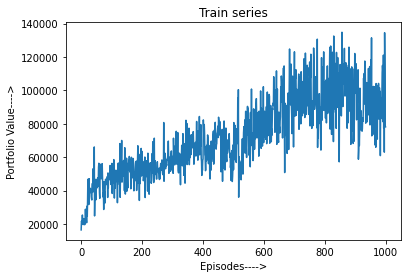

In [22]:
#Graph for training DQN network
plot_func("train")



In [29]:
main_func("test", 0.01)


      AAPL    MSI    SBUX
0  67.8542  60.30  28.185
1  68.5614  60.90  28.070
2  66.8428  60.83  28.130
3  66.7156  60.81  27.915
4  66.6556  61.12  27.775
episode: 1/1000, episode end value: 40844.96, duration: 0:00:00.091021
episode: 2/1000, episode end value: 39924.10, duration: 0:00:00.091021
episode: 3/1000, episode end value: 37989.69, duration: 0:00:00.092021
episode: 4/1000, episode end value: 39901.33, duration: 0:00:00.093021
episode: 5/1000, episode end value: 40397.18, duration: 0:00:00.091021
episode: 6/1000, episode end value: 41058.95, duration: 0:00:00.091021
episode: 7/1000, episode end value: 39926.64, duration: 0:00:00.089020
episode: 8/1000, episode end value: 35703.48, duration: 0:00:00.094021
episode: 9/1000, episode end value: 40228.07, duration: 0:00:00.099023
episode: 10/1000, episode end value: 39941.70, duration: 0:00:00.094021
episode: 11/1000, episode end value: 37523.03, duration: 0:00:00.090021
episode: 12/1000, episode end value: 38635.24, duration: 0:00

episode: 114/1000, episode end value: 38032.40, duration: 0:00:00.093022
episode: 115/1000, episode end value: 39950.96, duration: 0:00:00.090020
episode: 116/1000, episode end value: 39098.51, duration: 0:00:00.091021
episode: 117/1000, episode end value: 34943.04, duration: 0:00:00.091020
episode: 118/1000, episode end value: 39758.96, duration: 0:00:00.092021
episode: 119/1000, episode end value: 41008.77, duration: 0:00:00.092021
episode: 120/1000, episode end value: 33391.94, duration: 0:00:00.090021
episode: 121/1000, episode end value: 39925.55, duration: 0:00:00.089020
episode: 122/1000, episode end value: 41209.36, duration: 0:00:00.092021
episode: 123/1000, episode end value: 37076.02, duration: 0:00:00.090021
episode: 124/1000, episode end value: 40718.85, duration: 0:00:00.091021
episode: 125/1000, episode end value: 40481.90, duration: 0:00:00.091020
episode: 126/1000, episode end value: 40077.07, duration: 0:00:00.091021
episode: 127/1000, episode end value: 38322.97, dur

episode: 229/1000, episode end value: 33430.59, duration: 0:00:00.091021
episode: 230/1000, episode end value: 40014.63, duration: 0:00:00.092021
episode: 231/1000, episode end value: 39213.30, duration: 0:00:00.090021
episode: 232/1000, episode end value: 32133.95, duration: 0:00:00.090020
episode: 233/1000, episode end value: 42040.56, duration: 0:00:00.091021
episode: 234/1000, episode end value: 32900.68, duration: 0:00:00.090020
episode: 235/1000, episode end value: 40011.19, duration: 0:00:00.091021
episode: 236/1000, episode end value: 37878.50, duration: 0:00:00.091021
episode: 237/1000, episode end value: 36719.01, duration: 0:00:00.091020
episode: 238/1000, episode end value: 44778.56, duration: 0:00:00.092021
episode: 239/1000, episode end value: 39924.18, duration: 0:00:00.090021
episode: 240/1000, episode end value: 39924.18, duration: 0:00:00.090020
episode: 241/1000, episode end value: 37918.09, duration: 0:00:00.091021
episode: 242/1000, episode end value: 32630.92, dur

episode: 342/1000, episode end value: 41264.93, duration: 0:00:00.093122
episode: 343/1000, episode end value: 34827.78, duration: 0:00:00.089020
episode: 344/1000, episode end value: 39728.59, duration: 0:00:00.092021
episode: 345/1000, episode end value: 39924.18, duration: 0:00:00.090020
episode: 346/1000, episode end value: 38160.49, duration: 0:00:00.091021
episode: 347/1000, episode end value: 42497.78, duration: 0:00:00.089020
episode: 348/1000, episode end value: 40207.57, duration: 0:00:00.091021
episode: 349/1000, episode end value: 40894.76, duration: 0:00:00.089020
episode: 350/1000, episode end value: 39301.61, duration: 0:00:00.091021
episode: 351/1000, episode end value: 40788.78, duration: 0:00:00.091021
episode: 352/1000, episode end value: 40468.51, duration: 0:00:00.092021
episode: 353/1000, episode end value: 39924.18, duration: 0:00:00.090020
episode: 354/1000, episode end value: 39610.39, duration: 0:00:00.090021
episode: 355/1000, episode end value: 39853.10, dur

episode: 455/1000, episode end value: 39805.48, duration: 0:00:00.092021
episode: 456/1000, episode end value: 34824.86, duration: 0:00:00.090021
episode: 457/1000, episode end value: 33558.10, duration: 0:00:00.091020
episode: 458/1000, episode end value: 42449.45, duration: 0:00:00.091021
episode: 459/1000, episode end value: 38453.80, duration: 0:00:00.090021
episode: 460/1000, episode end value: 37419.09, duration: 0:00:00.090020
episode: 461/1000, episode end value: 39959.88, duration: 0:00:00.092021
episode: 462/1000, episode end value: 34462.40, duration: 0:00:00.089020
episode: 463/1000, episode end value: 39373.12, duration: 0:00:00.091021
episode: 464/1000, episode end value: 40426.36, duration: 0:00:00.090020
episode: 465/1000, episode end value: 37855.88, duration: 0:00:00.091021
episode: 466/1000, episode end value: 36075.57, duration: 0:00:00.090021
episode: 467/1000, episode end value: 39365.64, duration: 0:00:00.091020
episode: 468/1000, episode end value: 39857.17, dur

episode: 568/1000, episode end value: 39831.97, duration: 0:00:00.090021
episode: 569/1000, episode end value: 39398.68, duration: 0:00:00.092021
episode: 570/1000, episode end value: 36465.71, duration: 0:00:00.090020
episode: 571/1000, episode end value: 34542.73, duration: 0:00:00.091021
episode: 572/1000, episode end value: 38788.95, duration: 0:00:00.091021
episode: 573/1000, episode end value: 42645.85, duration: 0:00:00.090020
episode: 574/1000, episode end value: 34027.38, duration: 0:00:00.091517
episode: 575/1000, episode end value: 37202.61, duration: 0:00:00.089020
episode: 576/1000, episode end value: 41640.57, duration: 0:00:00.092021
episode: 577/1000, episode end value: 42456.60, duration: 0:00:00.091021
episode: 578/1000, episode end value: 35837.51, duration: 0:00:00.091020
episode: 579/1000, episode end value: 41469.70, duration: 0:00:00.089021
episode: 580/1000, episode end value: 42923.97, duration: 0:00:00.091020
episode: 581/1000, episode end value: 39584.74, dur

episode: 682/1000, episode end value: 42666.68, duration: 0:00:00.093021
episode: 683/1000, episode end value: 42475.01, duration: 0:00:00.090020
episode: 684/1000, episode end value: 41960.71, duration: 0:00:00.091021
episode: 685/1000, episode end value: 39191.25, duration: 0:00:00.091021
episode: 686/1000, episode end value: 42197.88, duration: 0:00:00.091020
episode: 687/1000, episode end value: 37723.40, duration: 0:00:00.091021
episode: 688/1000, episode end value: 40363.78, duration: 0:00:00.090020
episode: 689/1000, episode end value: 41223.57, duration: 0:00:00.091021
episode: 690/1000, episode end value: 33245.66, duration: 0:00:00.090021
episode: 691/1000, episode end value: 38401.41, duration: 0:00:00.090020
episode: 692/1000, episode end value: 36043.12, duration: 0:00:00.092021
episode: 693/1000, episode end value: 39904.77, duration: 0:00:00.091021
episode: 694/1000, episode end value: 38942.66, duration: 0:00:00.090020
episode: 695/1000, episode end value: 39845.41, dur

episode: 795/1000, episode end value: 40382.39, duration: 0:00:00.091020
episode: 796/1000, episode end value: 34351.96, duration: 0:00:00.089021
episode: 797/1000, episode end value: 39595.33, duration: 0:00:00.090020
episode: 798/1000, episode end value: 39758.39, duration: 0:00:00.091021
episode: 799/1000, episode end value: 33691.69, duration: 0:00:00.090020
episode: 800/1000, episode end value: 37815.06, duration: 0:00:00.090021
episode: 801/1000, episode end value: 39271.59, duration: 0:00:00.091021
episode: 802/1000, episode end value: 36576.95, duration: 0:00:00.090020
episode: 803/1000, episode end value: 32611.61, duration: 0:00:00.090021
episode: 804/1000, episode end value: 40301.61, duration: 0:00:00.081018
episode: 805/1000, episode end value: 38822.55, duration: 0:00:00.100760
episode: 806/1000, episode end value: 39475.42, duration: 0:00:00.090021
episode: 807/1000, episode end value: 39931.94, duration: 0:00:00.090021
episode: 808/1000, episode end value: 34016.93, dur

episode: 909/1000, episode end value: 39407.58, duration: 0:00:00.091021
episode: 910/1000, episode end value: 35021.12, duration: 0:00:00.089021
episode: 911/1000, episode end value: 43207.56, duration: 0:00:00.092119
episode: 912/1000, episode end value: 35844.68, duration: 0:00:00.090922
episode: 913/1000, episode end value: 38086.92, duration: 0:00:00.093021
episode: 914/1000, episode end value: 39500.07, duration: 0:00:00.091021
episode: 915/1000, episode end value: 42179.47, duration: 0:00:00.090021
episode: 916/1000, episode end value: 30969.82, duration: 0:00:00.089020
episode: 917/1000, episode end value: 40045.93, duration: 0:00:00.092021
episode: 918/1000, episode end value: 39916.46, duration: 0:00:00.090020
episode: 919/1000, episode end value: 39737.30, duration: 0:00:00.090021
episode: 920/1000, episode end value: 39693.83, duration: 0:00:00.090020
episode: 921/1000, episode end value: 42818.44, duration: 0:00:00.092021
episode: 922/1000, episode end value: 39923.63, dur

average reward: 39027.43, min: 28243.21, max: 46670.40, std: 2871.09


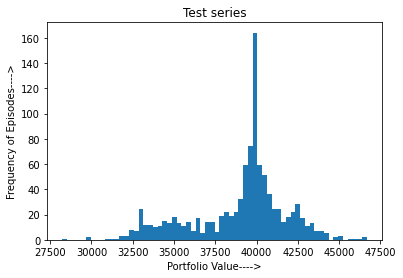

In [32]:
#Graph for testing probabilistic DQN network
plot_func("test")


In [33]:
main_func("test", 1)   #Complete random


      AAPL    MSI    SBUX
0  67.8542  60.30  28.185
1  68.5614  60.90  28.070
2  66.8428  60.83  28.130
3  66.7156  60.81  27.915
4  66.6556  61.12  27.775
episode: 1/1000, episode end value: 23006.68, duration: 0:00:00.078018
episode: 2/1000, episode end value: 20025.95, duration: 0:00:00.080018
episode: 3/1000, episode end value: 24398.43, duration: 0:00:00.081019
episode: 4/1000, episode end value: 24338.93, duration: 0:00:00.089020
episode: 5/1000, episode end value: 32880.50, duration: 0:00:00.091021
episode: 6/1000, episode end value: 24450.34, duration: 0:00:00.085019
episode: 7/1000, episode end value: 25680.15, duration: 0:00:00.090021
episode: 8/1000, episode end value: 28733.46, duration: 0:00:00.087019
episode: 9/1000, episode end value: 19769.03, duration: 0:00:00.079018
episode: 10/1000, episode end value: 24174.89, duration: 0:00:00.082019
episode: 11/1000, episode end value: 33153.80, duration: 0:00:00.088020
episode: 12/1000, episode end value: 26549.29, duration: 0:00

episode: 227/1000, episode end value: 23216.37, duration: 0:00:00.079018
episode: 228/1000, episode end value: 19152.39, duration: 0:00:00.079018
episode: 229/1000, episode end value: 16981.80, duration: 0:00:00.077018
episode: 230/1000, episode end value: 38417.44, duration: 0:00:00.094022
episode: 231/1000, episode end value: 30255.96, duration: 0:00:00.081018
episode: 232/1000, episode end value: 23528.99, duration: 0:00:00.080018
episode: 233/1000, episode end value: 23617.22, duration: 0:00:00.088020
episode: 234/1000, episode end value: 23981.69, duration: 0:00:00.085020
episode: 235/1000, episode end value: 32149.71, duration: 0:00:00.085019
episode: 236/1000, episode end value: 25699.94, duration: 0:00:00.083019
episode: 237/1000, episode end value: 33390.65, duration: 0:00:00.091020
episode: 238/1000, episode end value: 22453.31, duration: 0:00:00.075017
episode: 239/1000, episode end value: 28257.75, duration: 0:00:00.079018
episode: 240/1000, episode end value: 23806.69, dur

episode: 340/1000, episode end value: 26995.06, duration: 0:00:00.083019
episode: 341/1000, episode end value: 20791.46, duration: 0:00:00.079018
episode: 342/1000, episode end value: 26076.10, duration: 0:00:00.081018
episode: 343/1000, episode end value: 20339.11, duration: 0:00:00.078018
episode: 344/1000, episode end value: 21778.21, duration: 0:00:00.085019
episode: 345/1000, episode end value: 28626.39, duration: 0:00:00.084019
episode: 346/1000, episode end value: 24564.16, duration: 0:00:00.083019
episode: 347/1000, episode end value: 25177.91, duration: 0:00:00.086020
episode: 348/1000, episode end value: 31933.43, duration: 0:00:00.090020
episode: 349/1000, episode end value: 18317.73, duration: 0:00:00.080018
episode: 350/1000, episode end value: 23348.14, duration: 0:00:00.084019
episode: 351/1000, episode end value: 23853.09, duration: 0:00:00.080019
episode: 352/1000, episode end value: 20764.10, duration: 0:00:00.079018
episode: 353/1000, episode end value: 18178.84, dur

episode: 458/1000, episode end value: 25879.03, duration: 0:00:00.085019
episode: 459/1000, episode end value: 28386.92, duration: 0:00:00.084019
episode: 460/1000, episode end value: 19492.26, duration: 0:00:00.078018
episode: 461/1000, episode end value: 21788.17, duration: 0:00:00.076017
episode: 462/1000, episode end value: 21487.90, duration: 0:00:00.078018
episode: 463/1000, episode end value: 29206.80, duration: 0:00:00.088020
episode: 464/1000, episode end value: 26206.51, duration: 0:00:00.080018
episode: 465/1000, episode end value: 31685.89, duration: 0:00:00.080018
episode: 466/1000, episode end value: 26244.47, duration: 0:00:00.090021
episode: 467/1000, episode end value: 20817.51, duration: 0:00:00.077574
episode: 468/1000, episode end value: 20444.33, duration: 0:00:00.078017
episode: 469/1000, episode end value: 20466.75, duration: 0:00:00.083019
episode: 470/1000, episode end value: 20932.37, duration: 0:00:00.079018
episode: 471/1000, episode end value: 18972.40, dur

episode: 571/1000, episode end value: 24774.66, duration: 0:00:00.080018
episode: 572/1000, episode end value: 28984.49, duration: 0:00:00.085019
episode: 573/1000, episode end value: 22962.64, duration: 0:00:00.079018
episode: 574/1000, episode end value: 22709.52, duration: 0:00:00.080204
episode: 575/1000, episode end value: 18149.68, duration: 0:00:00.074017
episode: 576/1000, episode end value: 30497.38, duration: 0:00:00.082019
episode: 577/1000, episode end value: 26174.64, duration: 0:00:00.085019
episode: 578/1000, episode end value: 20792.23, duration: 0:00:00.084019
episode: 579/1000, episode end value: 29679.47, duration: 0:00:00.090021
episode: 580/1000, episode end value: 19786.43, duration: 0:00:00.080018
episode: 581/1000, episode end value: 23961.12, duration: 0:00:00.079018
episode: 582/1000, episode end value: 28711.46, duration: 0:00:00.091021
episode: 583/1000, episode end value: 24539.96, duration: 0:00:00.085019
episode: 584/1000, episode end value: 21815.49, dur

episode: 795/1000, episode end value: 29908.78, duration: 0:00:00.084020
episode: 796/1000, episode end value: 29583.78, duration: 0:00:00.086019
episode: 797/1000, episode end value: 23155.82, duration: 0:00:00.080018
episode: 798/1000, episode end value: 24204.70, duration: 0:00:00.080018
episode: 799/1000, episode end value: 17662.63, duration: 0:00:00.078018
episode: 800/1000, episode end value: 21916.93, duration: 0:00:00.076018
episode: 801/1000, episode end value: 21730.85, duration: 0:00:00.076017
episode: 802/1000, episode end value: 21161.12, duration: 0:00:00.077018
episode: 803/1000, episode end value: 28148.33, duration: 0:00:00.084019
episode: 804/1000, episode end value: 26768.88, duration: 0:00:00.080018
episode: 805/1000, episode end value: 24656.38, duration: 0:00:00.080018
episode: 806/1000, episode end value: 19473.47, duration: 0:00:00.075017
episode: 807/1000, episode end value: 41108.81, duration: 0:00:00.098023
episode: 808/1000, episode end value: 21078.21, dur

episode: 910/1000, episode end value: 23122.10, duration: 0:00:00.084019
episode: 911/1000, episode end value: 19513.65, duration: 0:00:00.077017
episode: 912/1000, episode end value: 25609.68, duration: 0:00:00.082019
episode: 913/1000, episode end value: 21644.78, duration: 0:00:00.084019
episode: 914/1000, episode end value: 31341.08, duration: 0:00:00.087020
episode: 915/1000, episode end value: 26118.64, duration: 0:00:00.078018
episode: 916/1000, episode end value: 18097.66, duration: 0:00:00.077018
episode: 917/1000, episode end value: 18145.41, duration: 0:00:00.075017
episode: 918/1000, episode end value: 18088.85, duration: 0:00:00.080018
episode: 919/1000, episode end value: 26088.69, duration: 0:00:00.091021
episode: 920/1000, episode end value: 28187.79, duration: 0:00:00.087020
episode: 921/1000, episode end value: 23968.48, duration: 0:00:00.085019
episode: 922/1000, episode end value: 28507.35, duration: 0:00:00.086020
episode: 923/1000, episode end value: 37349.77, dur

average reward: 25428.24, min: 13415.22, max: 48286.69, std: 5452.37


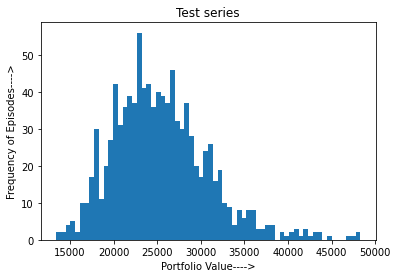

In [34]:
plot_func("test")
#Graph for testing complete random decisions

In [13]:
main_func("test", 0)   #Complete deterministic


      AAPL    MSI    SBUX
0  67.8542  60.30  28.185
1  68.5614  60.90  28.070
2  66.8428  60.83  28.130
3  66.7156  60.81  27.915
4  66.6556  61.12  27.775
episode: 1/1000, episode end value: 39924.18, duration: 0:00:00.090216
episode: 2/1000, episode end value: 39924.18, duration: 0:00:00.091021
episode: 3/1000, episode end value: 39924.18, duration: 0:00:00.090021
episode: 4/1000, episode end value: 39924.18, duration: 0:00:00.092021
episode: 5/1000, episode end value: 39924.18, duration: 0:00:00.091020
episode: 6/1000, episode end value: 39924.18, duration: 0:00:00.090021
episode: 7/1000, episode end value: 39924.18, duration: 0:00:00.091020
episode: 8/1000, episode end value: 39924.18, duration: 0:00:00.091021
episode: 9/1000, episode end value: 39924.18, duration: 0:00:00.090020
episode: 10/1000, episode end value: 39924.18, duration: 0:00:00.091021
episode: 11/1000, episode end value: 39924.18, duration: 0:00:00.092022
episode: 12/1000, episode end value: 39924.18, duration: 0:00

episode: 115/1000, episode end value: 39924.18, duration: 0:00:00.091021
episode: 116/1000, episode end value: 39924.18, duration: 0:00:00.090021
episode: 117/1000, episode end value: 39924.18, duration: 0:00:00.090020
episode: 118/1000, episode end value: 39924.18, duration: 0:00:00.091021
episode: 119/1000, episode end value: 39924.18, duration: 0:00:00.090020
episode: 120/1000, episode end value: 39924.18, duration: 0:00:00.090021
episode: 121/1000, episode end value: 39924.18, duration: 0:00:00.091020
episode: 122/1000, episode end value: 39924.18, duration: 0:00:00.090021
episode: 123/1000, episode end value: 39924.18, duration: 0:00:00.090021
episode: 124/1000, episode end value: 39924.18, duration: 0:00:00.090020
episode: 125/1000, episode end value: 39924.18, duration: 0:00:00.091021
episode: 126/1000, episode end value: 39924.18, duration: 0:00:00.090020
episode: 127/1000, episode end value: 39924.18, duration: 0:00:00.090021
episode: 128/1000, episode end value: 39924.18, dur

episode: 229/1000, episode end value: 39924.18, duration: 0:00:00.091020
episode: 230/1000, episode end value: 39924.18, duration: 0:00:00.090021
episode: 231/1000, episode end value: 39924.18, duration: 0:00:00.090021
episode: 232/1000, episode end value: 39924.18, duration: 0:00:00.091020
episode: 233/1000, episode end value: 39924.18, duration: 0:00:00.089439
episode: 234/1000, episode end value: 39924.18, duration: 0:00:00.090020
episode: 235/1000, episode end value: 39924.18, duration: 0:00:00.091021
episode: 236/1000, episode end value: 39924.18, duration: 0:00:00.090020
episode: 237/1000, episode end value: 39924.18, duration: 0:00:00.090021
episode: 238/1000, episode end value: 39924.18, duration: 0:00:00.091020
episode: 239/1000, episode end value: 39924.18, duration: 0:00:00.090021
episode: 240/1000, episode end value: 39924.18, duration: 0:00:00.094021
episode: 241/1000, episode end value: 39924.18, duration: 0:00:00.111026
episode: 242/1000, episode end value: 39924.18, dur

episode: 343/1000, episode end value: 39924.18, duration: 0:00:00.090021
episode: 344/1000, episode end value: 39924.18, duration: 0:00:00.090020
episode: 345/1000, episode end value: 39924.18, duration: 0:00:00.090021
episode: 346/1000, episode end value: 39924.18, duration: 0:00:00.090020
episode: 347/1000, episode end value: 39924.18, duration: 0:00:00.091021
episode: 348/1000, episode end value: 39924.18, duration: 0:00:00.090021
episode: 349/1000, episode end value: 39924.18, duration: 0:00:00.090020
episode: 350/1000, episode end value: 39924.18, duration: 0:00:00.090021
episode: 351/1000, episode end value: 39924.18, duration: 0:00:00.091020
episode: 352/1000, episode end value: 39924.18, duration: 0:00:00.091021
episode: 353/1000, episode end value: 39924.18, duration: 0:00:00.090020
episode: 354/1000, episode end value: 39924.18, duration: 0:00:00.090021
episode: 355/1000, episode end value: 39924.18, duration: 0:00:00.090020
episode: 356/1000, episode end value: 39924.18, dur

episode: 458/1000, episode end value: 39924.18, duration: 0:00:00.090020
episode: 459/1000, episode end value: 39924.18, duration: 0:00:00.090020
episode: 460/1000, episode end value: 39924.18, duration: 0:00:00.089020
episode: 461/1000, episode end value: 39924.18, duration: 0:00:00.091021
episode: 462/1000, episode end value: 39924.18, duration: 0:00:00.090021
episode: 463/1000, episode end value: 39924.18, duration: 0:00:00.090020
episode: 464/1000, episode end value: 39924.18, duration: 0:00:00.091021
episode: 465/1000, episode end value: 39924.18, duration: 0:00:00.090104
episode: 466/1000, episode end value: 39924.18, duration: 0:00:00.090020
episode: 467/1000, episode end value: 39924.18, duration: 0:00:00.090021
episode: 468/1000, episode end value: 39924.18, duration: 0:00:00.091021
episode: 469/1000, episode end value: 39924.18, duration: 0:00:00.089020
episode: 470/1000, episode end value: 39924.18, duration: 0:00:00.091020
episode: 471/1000, episode end value: 39924.18, dur

episode: 571/1000, episode end value: 39924.18, duration: 0:00:00.100022
episode: 572/1000, episode end value: 39924.18, duration: 0:00:00.095022
episode: 573/1000, episode end value: 39924.18, duration: 0:00:00.090020
episode: 574/1000, episode end value: 39924.18, duration: 0:00:00.091021
episode: 575/1000, episode end value: 39924.18, duration: 0:00:00.090020
episode: 576/1000, episode end value: 39924.18, duration: 0:00:00.090021
episode: 577/1000, episode end value: 39924.18, duration: 0:00:00.090020
episode: 578/1000, episode end value: 39924.18, duration: 0:00:00.090021
episode: 579/1000, episode end value: 39924.18, duration: 0:00:00.090020
episode: 580/1000, episode end value: 39924.18, duration: 0:00:00.091021
episode: 581/1000, episode end value: 39924.18, duration: 0:00:00.091021
episode: 582/1000, episode end value: 39924.18, duration: 0:00:00.089020
episode: 583/1000, episode end value: 39924.18, duration: 0:00:00.095021
episode: 584/1000, episode end value: 39924.18, dur

episode: 686/1000, episode end value: 39924.18, duration: 0:00:00.091021
episode: 687/1000, episode end value: 39924.18, duration: 0:00:00.091021
episode: 688/1000, episode end value: 39924.18, duration: 0:00:00.089020
episode: 689/1000, episode end value: 39924.18, duration: 0:00:00.091021
episode: 690/1000, episode end value: 39924.18, duration: 0:00:00.091020
episode: 691/1000, episode end value: 39924.18, duration: 0:00:00.090021
episode: 692/1000, episode end value: 39924.18, duration: 0:00:00.090021
episode: 693/1000, episode end value: 39924.18, duration: 0:00:00.090020
episode: 694/1000, episode end value: 39924.18, duration: 0:00:00.090020
episode: 695/1000, episode end value: 39924.18, duration: 0:00:00.091021
episode: 696/1000, episode end value: 39924.18, duration: 0:00:00.089020
episode: 697/1000, episode end value: 39924.18, duration: 0:00:00.091495
episode: 698/1000, episode end value: 39924.18, duration: 0:00:00.091021
episode: 699/1000, episode end value: 39924.18, dur

episode: 800/1000, episode end value: 39924.18, duration: 0:00:00.091020
episode: 801/1000, episode end value: 39924.18, duration: 0:00:00.090021
episode: 802/1000, episode end value: 39924.18, duration: 0:00:00.090020
episode: 803/1000, episode end value: 39924.18, duration: 0:00:00.090021
episode: 804/1000, episode end value: 39924.18, duration: 0:00:00.090020
episode: 805/1000, episode end value: 39924.18, duration: 0:00:00.090021
episode: 806/1000, episode end value: 39924.18, duration: 0:00:00.090020
episode: 807/1000, episode end value: 39924.18, duration: 0:00:00.090021
episode: 808/1000, episode end value: 39924.18, duration: 0:00:00.091021
episode: 809/1000, episode end value: 39924.18, duration: 0:00:00.090020
episode: 810/1000, episode end value: 39924.18, duration: 0:00:00.090021
episode: 811/1000, episode end value: 39924.18, duration: 0:00:00.090020
episode: 812/1000, episode end value: 39924.18, duration: 0:00:00.090021
episode: 813/1000, episode end value: 39924.18, dur

episode: 913/1000, episode end value: 39924.18, duration: 0:00:00.090021
episode: 914/1000, episode end value: 39924.18, duration: 0:00:00.090020
episode: 915/1000, episode end value: 39924.18, duration: 0:00:00.090021
episode: 916/1000, episode end value: 39924.18, duration: 0:00:00.091021
episode: 917/1000, episode end value: 39924.18, duration: 0:00:00.091020
episode: 918/1000, episode end value: 39924.18, duration: 0:00:00.090021
episode: 919/1000, episode end value: 39924.18, duration: 0:00:00.090021
episode: 920/1000, episode end value: 39924.18, duration: 0:00:00.090020
episode: 921/1000, episode end value: 39924.18, duration: 0:00:00.091021
episode: 922/1000, episode end value: 39924.18, duration: 0:00:00.090020
episode: 923/1000, episode end value: 39924.18, duration: 0:00:00.090021
episode: 924/1000, episode end value: 39924.18, duration: 0:00:00.091020
episode: 925/1000, episode end value: 39924.18, duration: 0:00:00.090021
episode: 926/1000, episode end value: 39924.18, dur

average reward: 39924.18, min: 39924.18, max: 39924.18


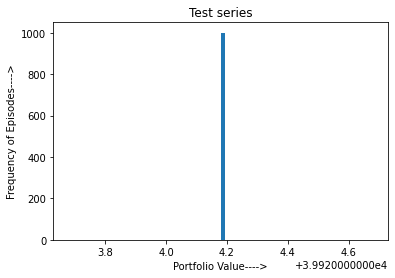

In [23]:
#Graph for testing deterministic DQN network
plot_func("test")